##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

## Concepts that will be covered in this Colab

1. Use a TensorFlow Hub model for prediction.
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset.
3. Do simple transfer learning with TensorFlow Hub.

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which was installed above, and which this Colab will make heavy use of.

In [2]:
import tensorflow as tf
import os
import cv2

In [3]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [5]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


## Run it on a single image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

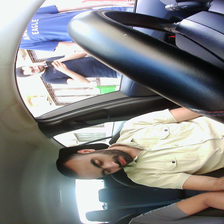

In [7]:


# run it on a single image 

me = tf.keras.utils.load_img(('me.jpg'))
me = me.resize((IMAGE_RES, IMAGE_RES), Image.LANCZOS)
me = me.rotate(90)
me

In [8]:
me = np.array(me)/255.0
me.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [9]:
result = model.predict(me[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

786

## Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

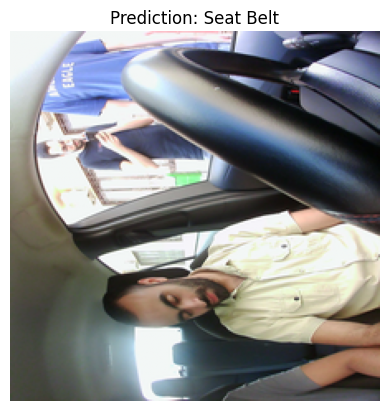

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(me)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Bingo. Our model correctly predicted military uniform!

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [12]:
# Define a mapping from string labels to integers
data_directory = 'collectedimages'
label_mapping = {'Abdulrahman_Osama': 0, 'Mahmoud_Mousa': 1, 'Mohamed_Magdi': 2, 'Mohamed_Nour': 3, 'Unknown': 4}

# Reading all images and converting them into an array for data and labels
img_size = 224

def create_training_data(directory, training_data):
    for i, category in enumerate(label_mapping):
        path = os.path.join(directory, category)
        class_num = i
        for img in os.listdir(path):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size, img_size))
                training_data.append([new_array, class_num])

    return training_data
        

In [13]:
def load_data(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        # Use the integer label corresponding to the string label
        int_label = label_mapping[label]
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            backtorgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(backtorgb, (IMAGE_RES, IMAGE_RES))
            images.append(img)
            labels.append(int_label)

    return np.array(images, dtype=np.uint8), np.array(labels)

# Assuming you have loaded images and labels using the load_data function
images, labels = load_data('collectedimages')
print(len(labels))
# Convert labels to tf.int64
labels = labels.astype(np.int64)

# Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))


# Assuming you have loaded images and labels using the load_data function
imagesVal, labelsVal = load_data('collectedimages')
# Convert labels to tf.int64
labelsVal = labelsVal.astype(np.int64)

# Create a tf.data.Dataset
valDataset = tf.data.Dataset.from_tensor_slices((imagesVal, labelsVal))

BATCH_SIZE = 32

# Shuffle and batch the dataset
#dataset = dataset.shuffle(buffer_size=len(images)).batch(BATCH_SIZE)


collectedimages\Abdulrahman_Osama\face_roi71.jpg
collectedimages\Abdulrahman_Osama\face_roi72.jpg
collectedimages\Abdulrahman_Osama\face_roi73.jpg
collectedimages\Abdulrahman_Osama\face_roi76.jpg
collectedimages\Abdulrahman_Osama\face_roi77.jpg
collectedimages\Abdulrahman_Osama\face_roi79.jpg
collectedimages\Abdulrahman_Osama\face_roi80.jpg
collectedimages\Abdulrahman_Osama\face_roi81.jpg
collectedimages\Abdulrahman_Osama\face_roi82.jpg
collectedimages\Abdulrahman_Osama\face_roi83.jpg
collectedimages\Abdulrahman_Osama\face_roi84.jpg
collectedimages\Abdulrahman_Osama\face_roi86.jpg
collectedimages\Abdulrahman_Osama\image (73).jpg
collectedimages\Abdulrahman_Osama\image (74).jpg
collectedimages\Abdulrahman_Osama\image (75).jpg
collectedimages\Abdulrahman_Osama\image (76).jpg
collectedimages\Abdulrahman_Osama\image (77).jpg
collectedimages\Abdulrahman_Osama\image (78).jpg
collectedimages\Abdulrahman_Osama\image (79).jpg
collectedimages\Abdulrahman_Osama\image (80).jpg
collectedimages\Abdu

In [14]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes


In [15]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
train_examples.take(1)


<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

The images in the Dogs vs. Cats dataset are not all the same size.

In [17]:
for i, example_image in enumerate(dataset.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [18]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))
  image = image / 255.0
  return image, label

BATCH_SIZE = 32

#train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
#validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(len(dataset))
datasetBatch = dataset.shuffle(buffer_size=len(images)).batch(BATCH_SIZE)
datasetBatch = datasetBatch.map(format_image)

valDatasetBatch = valDataset.shuffle(buffer_size=len(imagesVal)).batch(BATCH_SIZE)
valDatasetBatch = valDatasetBatch.map(format_image)
datasetBatch.take(1)

169


<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Run the classifier on a batch of images

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


In [20]:
image_batch, label_batch = next(iter(datasetBatch.take(11)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 2s 2s/step


array(['oxygen mask', 'cellular telephone', 'bow tie', 'Boston bull',
       'bow tie', 'Band Aid', 'bow tie', 'Weimaraner', 'lipstick', 'mask',
       'seat belt', 'lipstick', 'bow tie', 'lipstick', 'Band Aid',
       'Band Aid', 'bow tie', 'scorpion', 'cowboy hat', 'seat belt',
       'bow tie', 'Band Aid', 'Band Aid', 'mask', 'seat belt', 'bow tie',
       'seat belt', 'bow tie', 'microphone', 'bow tie', 'seat belt',
       'Band Aid'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

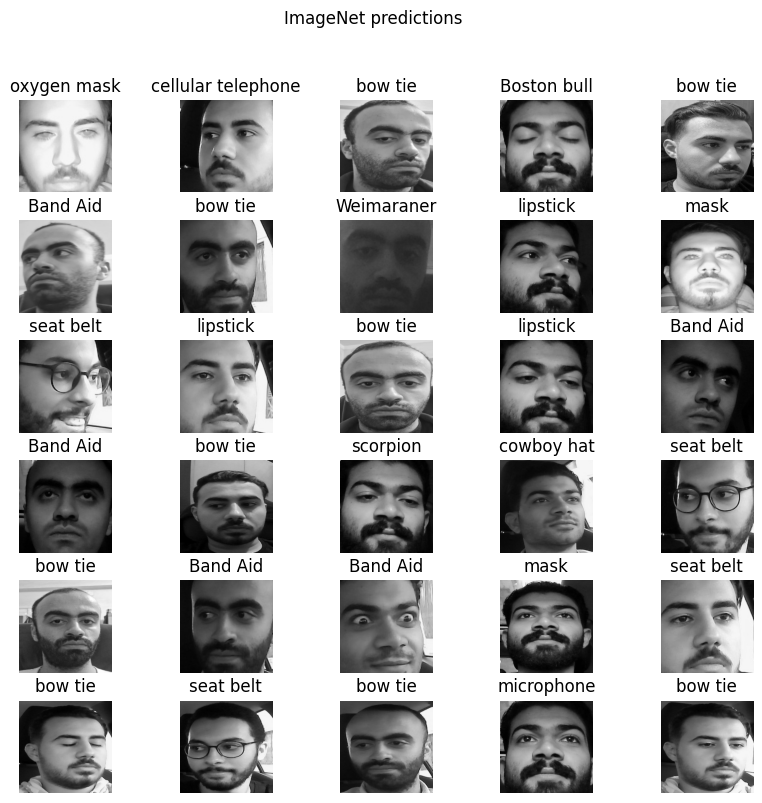

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [22]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [23]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [21]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [24]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(5, activation='softmax', name='moAlsehli')
])

model.summary()
type(dataset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 moAlsehli (Dense)           (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 15
history = model.fit(datasetBatch,
                    epochs=EPOCHS, steps_per_epoch=int(np.ceil(len(dataset) / float(BATCH_SIZE))), validation_steps=int(np.ceil(len(valDataset) / float(BATCH_SIZE))), validation_data=valDatasetBatch)

Epoch 1/15


6/6 [==============================] - 19s 3s/step - loss: 0.0982 - accuracy: 0.9941 - val_loss: 0.0754 - val_accuracy: 0.9941
Epoch 2/15
6/6 [==============================] - 15s 3s/step - loss: 0.0757 - accuracy: 0.9941 - val_loss: 0.0631 - val_accuracy: 0.9941
Epoch 3/15
6/6 [==============================] - 13s 2s/step - loss: 0.0600 - accuracy: 0.9941 - val_loss: 0.0539 - val_accuracy: 0.9941
Epoch 4/15
6/6 [==============================] - 11s 2s/step - loss: 0.0541 - accuracy: 0.9941 - val_loss: 0.0456 - val_accuracy: 0.9941
Epoch 5/15
6/6 [==============================] - 11s 2s/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.0402 - val_accuracy: 1.0000
Epoch 6/15
6/6 [==============================] - 11s 2s/step - loss: 0.0377 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 1.0000
Epoch 7/15
6/6 [==============================] - 11s 2s/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 8/15
6/6 [=============================

You can see we get ~97% validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~83% accuracy. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Let's plot the training and validation accuracy/loss graphs.

In [28]:
# To resolve An issue when saving the model
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

In [29]:
import os
import time

# Append a timestamp to the file name
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f'models/Person_Identify_{timestamp}.h5'

# Save the model
model.save(model_path)

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
tf.data.experimental.save(
    datasetBatch, "saved_datasets"
)

In [31]:
datasetBatch = tf.data.experimental.load("saved_datasets")

In [32]:
# Save dataset
tensor_data = tf.constant(datasetBatch, dtype=tf.DType.to_tensors())

# Convert the tensor to a binary string
tensor_binary = tf.io.serialize_tensor(tensor_data)

# Specify the file path
file_path = 'saved_dataset/tensor_data.tfrecord'

 #Write the binary string to a file
tf.io.write_file(file_path, tensor_binary)

AttributeError: type object 'DType' has no attribute 'to_tensors'

In [6]:
new_model = tf.keras.models.load_model('models/Person_Identify_20240125-235552.h5', custom_objects={'KerasLayer':hub.KerasLayer})

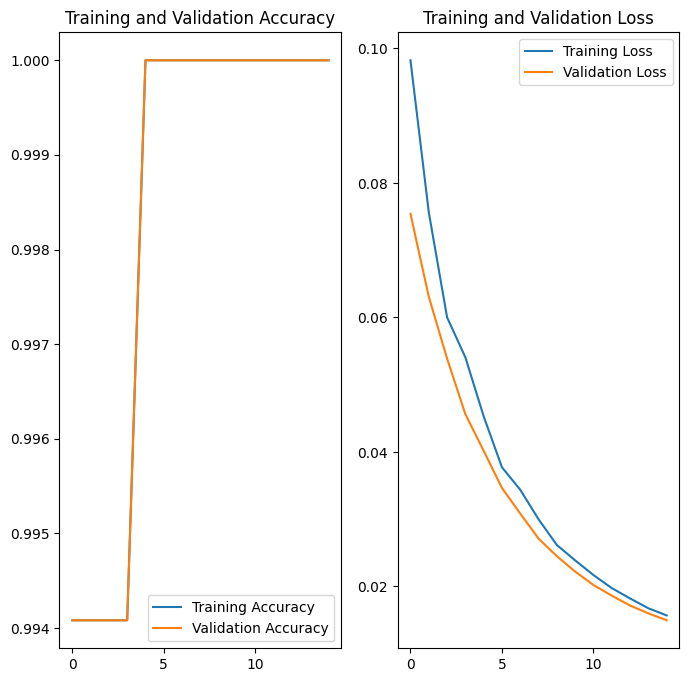

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [67]:
labels = label_mapping.items()
class_names = np.array([key for key, value in labels])
print(class_names)

['Abdulrahman_Osama' 'Mahmoud_Mousa' 'Mohamed_Magdi' 'Mohamed_Nour'
 'Unknown']


Run the image batch through the model and convert the indices to class names.

In [68]:
predicted_batch = new_model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 2s 2s/step


array(['Mohamed_Nour', 'Mohamed_Nour', 'Mohamed_Magdi', 'Mahmoud_Mousa',
       'Mohamed_Nour', 'Mohamed_Magdi', 'Mohamed_Magdi', 'Mohamed_Magdi',
       'Mahmoud_Mousa', 'Mohamed_Nour', 'Abdulrahman_Osama',
       'Mohamed_Nour', 'Mohamed_Magdi', 'Mahmoud_Mousa', 'Mohamed_Magdi',
       'Mohamed_Magdi', 'Mohamed_Nour', 'Mahmoud_Mousa', 'Mahmoud_Mousa',
       'Abdulrahman_Osama', 'Mohamed_Magdi', 'Mohamed_Magdi',
       'Mahmoud_Mousa', 'Mahmoud_Mousa', 'Mohamed_Nour', 'Mohamed_Nour',
       'Abdulrahman_Osama', 'Mohamed_Magdi', 'Mahmoud_Mousa',
       'Mohamed_Nour', 'Abdulrahman_Osama', 'Mohamed_Magdi'], dtype='<U17')

Let's look at the true labels and predicted ones.

In [69]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [3 3 2 1 3 2 2 2 1 3 0 3 2 1 2 2 3 1 1 0 2 2 1 1 3 3 0 2 1 3 0 2]
Predicted labels:  [3 3 2 1 3 2 2 2 1 3 0 3 2 1 2 2 3 1 1 0 2 2 1 1 3 3 0 2 1 3 0 2]


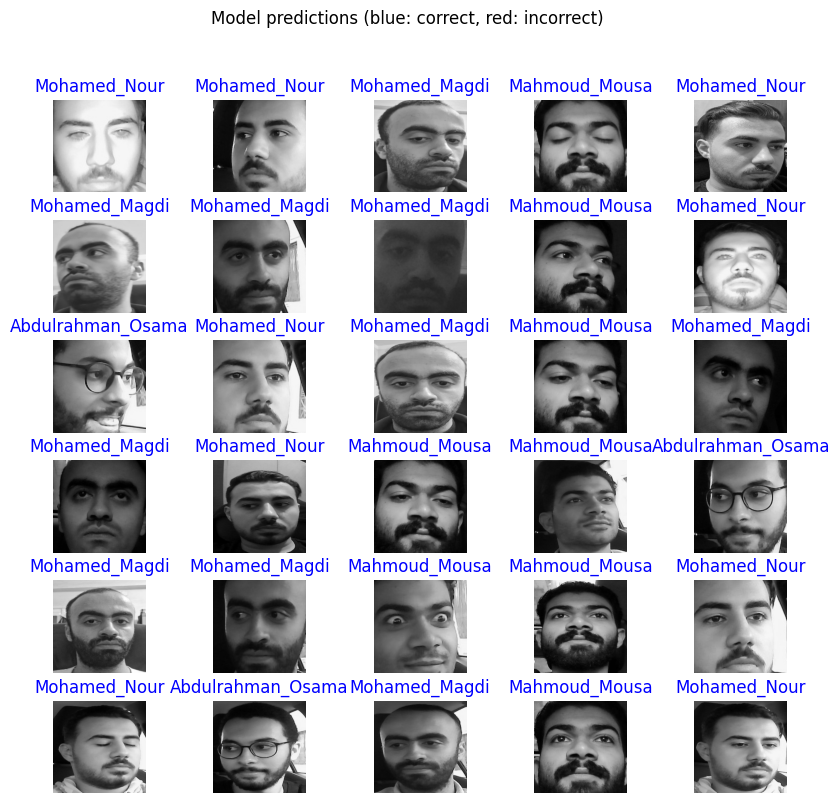

In [70]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [59]:
# Haar Cascade
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface_extended.xml')

In [60]:
img = cv2.imread("mousa.jpg")
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [61]:
face = faceCascade.detectMultiScale(imgGray, 1.3, 1)

In [62]:
for(x, y, w, h) in face:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

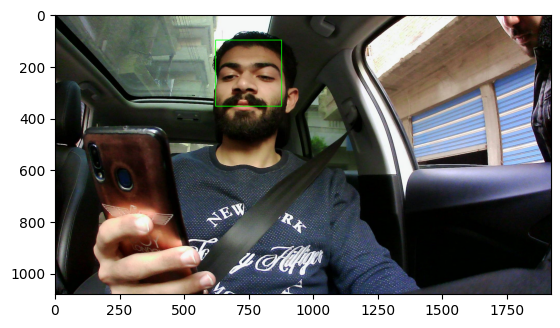

In [63]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Face is not detected


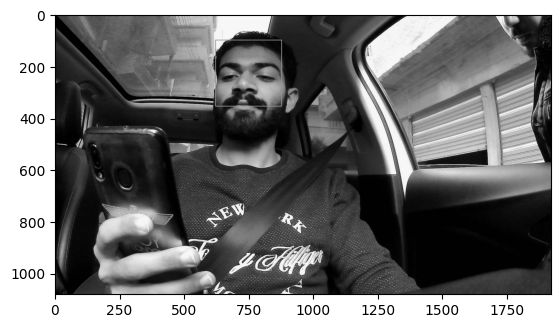

In [68]:
# Cropping the Face Image
faces = None
face_roi = None
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalcatface_extended.xml')
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(imgGray, cv2.COLOR_BGR2RGB))
# For detecting if there are multiple eyes
face = face_cascade.detectMultiScale(imgGray, 1.1, 4)
#print(face)
for x, y, w, h in face:
    roi_gray = imgGray[y:y+h, x: x+w]
    roi_color = img[y:y+h, x:x+w]
    faces = faceCascade.detectMultiScale(roi_gray)
    #print(faces)
    if len(faces) == 0:
        print("Face is not detected")
    else:
        for(ex, ey, ew, eh) in faces:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]
            print("Here")


In [65]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [47]:
# Load and preprocess an image for prediction
def preprocess_image(face_roi):
    # Load the image using OpenCV
    img = face_roi
    
    # Convert the image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the required input shape
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # Normalize the pixel values to be in the range [0, 1]
    img_normalized = img_resized / 255.0
    
    # Add a batch dimension to the image
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    return img_batch


In [48]:

""" final_image = cv2.resize(eyes_roi, (224, 224))
final_image = np.expand_dims(final_image, axis = 0) ## need fourth dimension
final_image = final_image / 255.0

image = tf.image.resize(final_image, (IMAGE_RES, IMAGE_RES))
image = image / 255.0 """

image = preprocess_image(face_roi)


In [49]:
predictions = new_model.predict(image)
print(predictions)
if max(predictions[0]) == predictions[0][3]:
   print("YSSS")
   print(max(predictions[0]))


1/1 [==============================] - 0s 81ms/step
[[1.7913782e-04 2.4099976e-01 4.4101491e-03 7.5441098e-01 8.1548075e-09]]
YSSS
0.754411


In [110]:
cap = cv2.VideoCapture(0)
""" if not cap.isOpened():
    cap = cv2.VideoCapture(0) """
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    # Cropping the Eye Image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    imgGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face = face_cascade.detectMultiScale(imgGray, 1.1, 4)
    for x, y, w, h in face:
        roi_gray = imgGray[y: y+h, x: x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        faces = face_cascade.detectMultiScale(roi_gray)
        if len(faces) == 0:
            print("Face is not detected")
            status = "Unkown"
        else:
            for(ex, ey, ew, eh) in faces:
                face_roi = roi_color[ey: ey+eh, ex:ex+ew]
            final_image = preprocess_image(face_roi)
            predictions = new_model.predict(final_image)
            maxPrediction = max(predictions[0])
            print(maxPrediction)
            if(maxPrediction == predictions[0][0]):
                status = f"Abdulrahman_Osama: {round(predictions[0][0]*100)}%"
            elif(maxPrediction == predictions[0][1]):
                status = f"Mahmoud_Mousa: {round(predictions[0][1]*100)}%"
            elif(maxPrediction == predictions[0][2]):
                status = f"Mohamed_Magdi: {round(predictions[0][2]*100)}%"
            elif(maxPrediction == predictions[0][3]):
                status = f"Mohamed_Nour: {round(predictions[0][3]*100)}%"
            elif(maxPrediction == predictions[0][4]):
                status = "Unknown"
                print("Max Here")
    

    imgGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(imgGray, 1.1, 4)

    # Draw a rectangle around the face
    for(x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    font = cv2.FONT_HERSHEY_COMPLEX

    cv2.putText(frame, status, (180, 180), font, 1, (72, 49, 72), 3, cv2.LINE_4)
    cv2.imshow('Person Identification Tutorial', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    


1/1 [==============================] - 0s 146ms/step
0.78376937
1/1 [==============================] - 0s 131ms/step
0.97133374
1/1 [==============================] - 0s 132ms/step
0.65972877
1/1 [==============================] - 0s 109ms/step
0.88531685
1/1 [==============================] - 0s 162ms/step
0.99197
1/1 [==============================] - 0s 151ms/step
0.9905715
1/1 [==============================] - 0s 128ms/step
0.98707855
1/1 [==============================] - 0s 129ms/step
0.5654626
1/1 [==============================] - 0s 98ms/step
0.97971857
1/1 [==============================] - 0s 110ms/step
0.9119931
1/1 [==============================] - 0s 135ms/step
0.98763067
1/1 [==============================] - 0s 128ms/step
0.9782865
1/1 [==============================] - 0s 116ms/step
0.9590308
Face is not detected
1/1 [==============================] - 0s 136ms/step
0.91161853
1/1 [==============================] - 0s 143ms/step
0.9353333
1/1 [========================